In [75]:
from math import exp
import numpy as np

### Initialization ###
Initialize the scalar constants and variables.

In [76]:
Vrest = -65     # Resting membrane voltage, unit: mV
Cm    =  1      # Specific membrane capacitance, unit: uF / cm^2

EK    = -77     # Potassium Nernst voltage, unit: mV
ENa   =  50     # Sodium Nernst voltage, unit: mV
EL    = -54.387 # Leak current equilibrium, unit: mV

GNa = 120       # Max sodium channel conductance, unit: mS / cm^2
GK  = 36        # Max potassium channel conductance, unit: mS / cm^2
GL  = 0.3       # Leak current conductivity

n0 = 0.317711   # Initial n-gate value
m0 = 0.053      # Initial m-gate value
h0 = 0.596385   # Initial h-gate value

dt = 0.0005     # Integration time step, unit: ms
tend = 25       # Integration end time, unit: ms

IStim = 25      # Stimulus current, unit: pA/pF
tstim = 1       # Stimulus duration, unit: ms
tstim2 = 20

In [77]:
num_timesteps = int(tend/dt)

timesteps = np.linspace(0, tend, num_timesteps)

alpha_n = np.zeros([num_timesteps])
beta_n  = np.zeros([num_timesteps])
alpha_m = np.zeros([num_timesteps])
beta_m  = np.zeros([num_timesteps])
alpha_h = np.zeros([num_timesteps])
beta_h  = np.zeros([num_timesteps])

n       = np.zeros([num_timesteps])
m       = np.zeros([num_timesteps])
h       = np.zeros([num_timesteps])

IK      = np.zeros([num_timesteps])
INa     = np.zeros([num_timesteps])
IL      = np.zeros([num_timesteps])
V       = np.zeros([num_timesteps])

### Calculation ###
Calculate sodium, potassium, and leak current, then integrate the transmembrane voltage over time. Don't forget to aplly the stimulus current.

In [78]:
n[0] = n0
m[0] = m0
h[0] = h0

V[0] = Vrest

IK[0] = GK * n[0]**4 * (V[0] - EK)
INa[0] = GNa * m[0]**3 * h[0] * (V[0] - ENa)
IL[0] = GL * (V[0] - EL)

for i, t in enumerate(timesteps):
    Vm = V[i]

    if Vm == -55:
        alpha_n[i] = 0.1
    else:
        alpha_n[i] = 0.01 * -(Vm+55) / (exp(-(Vm+55)/10) - 1)
    beta_n[i]  = 0.125 * exp( -(Vm+65) / 80)

    if Vm == -40:
        alpha_m[i] = 1
    else:
        alpha_m[i] = 0.1 * -(Vm+40) / (exp(-(Vm+40)/10) - 1)
    beta_m[i]  = 4 * exp(-(Vm+65) / 18)

    alpha_h[i] = 0.07 * exp(-(Vm+65)/20)
    beta_h[i]  = 1 / (exp(-(Vm+35)/10) + 1)

    if i < num_timesteps - 1:
        dn_dt = alpha_n[i] * (1 - n[i]) - beta_n[i] * n[i]
        n[i+1] = n[i] + dn_dt * dt
        IK[i+1] = GK * n[i]**4 * (Vm - EK)

        dm_dt = alpha_m[i] * (1 - m[i]) - beta_m[i] * m[i]
        m[i+1] = m[i] + dm_dt * dt

        dh_dt = alpha_h[i] * (1 - h[i]) - beta_h[i] * h[i]
        h[i+1] = h[i] + dh_dt * dt

        INa[i+1] = GNa * m[i]**3 * h[i] * (Vm - ENa)

        IL[i+1] = GL * (Vm - EL)
        
        if t < tstim or tstim2 < t < tstim2+tstim:
            stim = IStim
        else:
            stim = 0

        dV_dt = (stim - INa[i] - IK[i] -IL[i]) / Cm
        V[i+1] = V[i] + dV_dt * dt

### Plotting of Results ###
The following cell is intended to plot your results.
It expects the arrays or lists `timesteps`, `n`, `m`, `h`, `IK`, `INa`, `IL`, and `V` to be defined and of equal length.

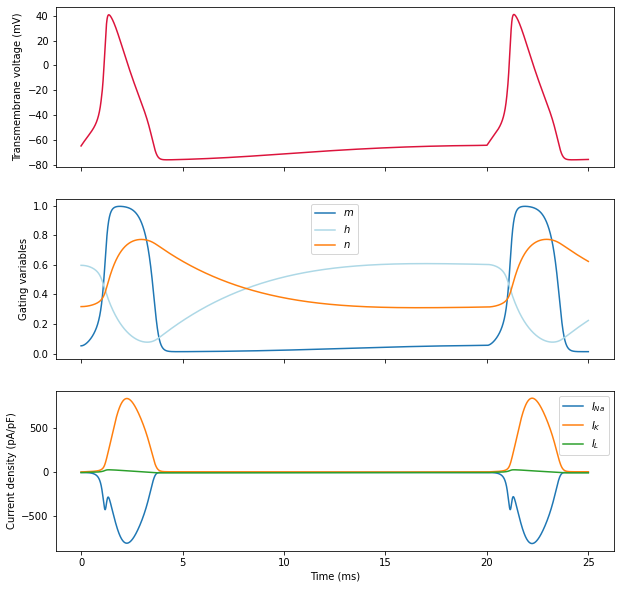

In [79]:
# Make sure the matrices are in numpy format for the plotting code
_t = np.array(timesteps)
_n = np.array(n)
_m = np.array(m)
_h = np.array(h)
_i_k = np.array(IK)
_i_na = np.array(INa)
_i_l = np.array(IL)
_v = np.array(V)

from matplotlib import pyplot as plt

_, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=(10,10))
axes[0].plot(_t, _v, color='crimson')
axes[0].set_ylabel('Transmembrane voltage (mV)')

axes[1].plot(_t, _m, label='$m$', color='tab:blue')
axes[1].plot(_t, _h, label='$h$', color='lightblue')
axes[1].plot(_t, _n, label='$n$', color='tab:orange')
axes[1].set_ylabel('Gating variables')
axes[1].legend()

axes[2].plot(_t, _i_na, label='$I_{Na}$')
axes[2].plot(_t, _i_k, label='$I_{K}$')
axes[2].plot(_t, _i_l, label='$I_{L}$')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Current density (pA/pF)')
axes[2].legend()
# axes[2].set_xlim((0,5))

plt.show()